In [1]:
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym
import quantstats as qs
# import gym_anytrading

import sys
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/gym-anytrading/gym_anytrading")
import importlib
%load_ext autoreload
%autoreload 2
from envs import MyForexEnv, Actions
# sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/gym-anytrading/")
# from datasets import FOREX_EURUSD_RENKO
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback
import torch

In [2]:
name = 'FOREX_EURUSD_RENKO'
# base_dir = os.path.dirname(os.path.abspath(__file__))
path = "C:/Users/WilliamFetzner/Documents/Trading/gym-anytrading/gym_anytrading/datasets/data/renko_full_data_50.csv"
# path = os.path.join(base_dir, '.csv')
FOREX_EURUSD_RENKO = pd.read_csv(path, parse_dates=True, index_col='datetime')

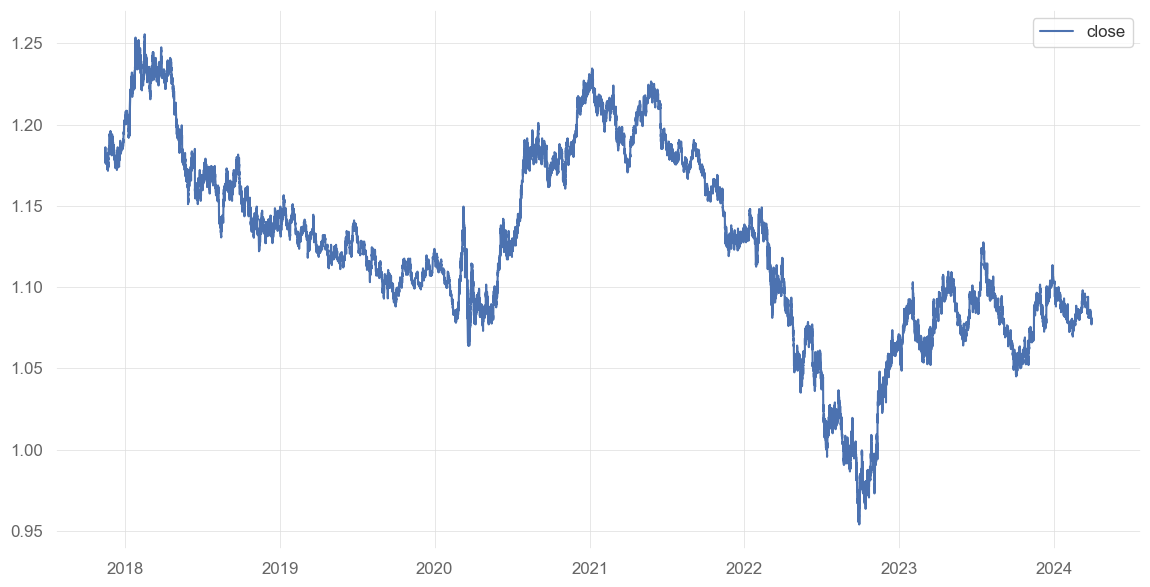

In [3]:
# plot the close price over time
plt.figure(figsize=(14, 7))
plt.plot(FOREX_EURUSD_RENKO.close, label='close')
plt.legend()
plt.show()


In [4]:
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max


# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()

In [5]:
# find the max date for FOREX_EURUSD_RENKO
max_date = FOREX_EURUSD_RENKO.index.max()
# get the month of the max date
max_date_month = max_date.month
second_to_last_month = max_date_month - 1
# find the row index for the last day of the second to last month
second_to_last_month_day = FOREX_EURUSD_RENKO[FOREX_EURUSD_RENKO.index.month == second_to_last_month].index.max()
split = FOREX_EURUSD_RENKO.loc[:second_to_last_month_day].shape[0]

In [6]:
env_train = MyForexEnv(
    df=FOREX_EURUSD_RENKO,
    window_size=10,
    frame_bound=(10, int(split)),
    trade_fee=0.0001,
    spread=0.0001,
    spread_bool=False,
    unit_side='right',
    sma_length=4,
    smoothing_sma=4
)
print(split)

83343


In [69]:
seed_ppo = 42  # random seed
obs_ppo, info_ppo = env_train.reset(seed=seed_ppo)
torch.manual_seed(seed_ppo)
random.seed(seed_ppo)
np.random.seed(seed_ppo)

vec_env_ppo = None

total_learning_timesteps_ppo = 5000 * 1000 # 5000
policy_dict_ppo = PPO.policy_aliases
policy_ppo = policy_dict_ppo.get('MlpPolicy')
if policy_ppo is None:
    policy_ppo = policy_dict_ppo.get('MlpLstmPolicy')

model_ppo = PPO(policy_ppo, env_train, verbose=0)

print(f'model {type(model_ppo)}')
print(f'policy {type(model_ppo.policy)}')

# custom callback for 'progress_bar'
model_ppo.learn(total_timesteps=total_learning_timesteps_ppo, callback=ProgressBarCallback(100))

env_train.close()

model <class 'stable_baselines3.ppo.ppo.PPO'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


model.learn(): 5001200it [2:30:45, 552.89it/s]                               


In [11]:
start_index = int(split)
end_index = int(len(FOREX_EURUSD_RENKO))-((int(len(FOREX_EURUSD_RENKO))-split) % 10)
print(f'start_index: {start_index} \nend_index: {end_index}')

start_index: 83343 
end_index: 83733


In [71]:
env_test = MyForexEnv(
    df=FOREX_EURUSD_RENKO,
    window_size=10,
    frame_bound=(start_index, end_index),
    trade_fee=0.0001,
    spread=0.0001,
    spread_bool=False,
    unit_side='right',
    sma_length=4,
    smoothing_sma=4
)

In [72]:
env_test.signal_features[0]

array([ 1.0815001e+00,  1.0820000e+00,  1.0807199e+00,  1.0820000e+00,
        1.0814350e+00,  1.0812117e+00,  2.2328125e-04,  1.0000000e+00,
        0.0000000e+00,  2.4082146e-03, -1.2267647e-04,  0.0000000e+00,
        0.0000000e+00,  2.0687791e+03], dtype=float32)

# Random Actions

info: {'total_reward': -60.002803802490234, 'total_profit': 0.9875027290398094, 'position': <Positions.Long: 1>}


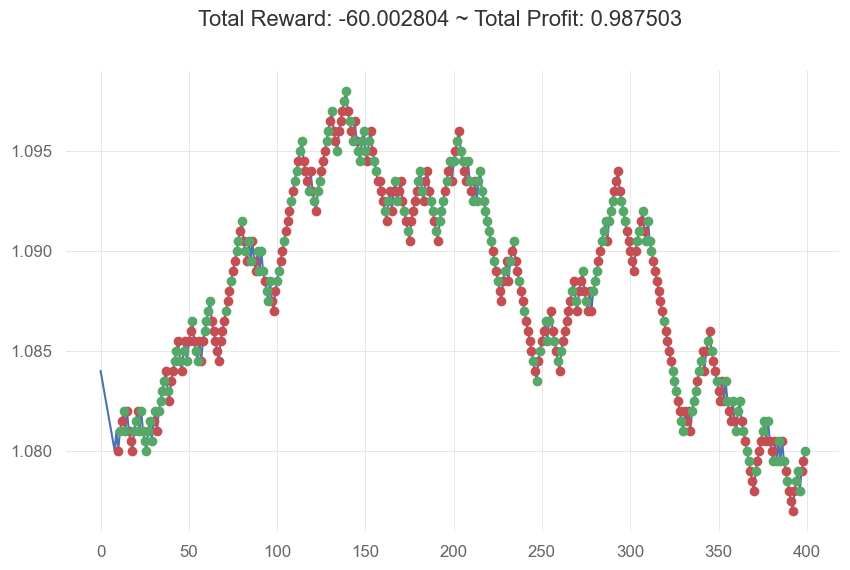

In [73]:
observation = env_test.reset(seed=seed_ppo)
action_stats_rdm = {Actions.Sell: 0, Actions.Buy: 0}
while True:
    action_rdm = env_test.action_space.sample()
    action_stats_rdm[Actions(action_rdm)] += 1
    observation, reward, terminated, truncated, info = env_test.step(action_rdm)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env_test.unwrapped.render_all()
plt.show()

# Model Performance

In [74]:
done = False
action_stats = {Actions.Sell: 0, Actions.Buy: 0}
test_obs, info_ppo = env_test.reset(seed=seed_ppo)
rows = test_obs.shape[0]

while not done:
    if test_obs.shape[0] != rows:
        # print(test_obs)
        diff = rows - test_obs.shape[0]
        test_obs = np.concatenate([test_obs, np.zeros((diff, test_obs.shape[1]))])
        # print(test_obs.shape)    
    action_ppo, _states = model_ppo.predict(test_obs)
    action_stats[Actions(action_ppo)] += 1
    test_obs, reward_ppo, terminated, truncated, info_ppo = env_test.step(action_ppo)
    done = terminated or truncated

    if done:
        break

env_test.close()

print("action_stats:", action_stats)
print("info:", info_ppo)

action_stats: {<Actions.Sell: 0>: 363, <Actions.Buy: 1>: 26}
info: {'total_reward': 90.00062942504883, 'total_profit': 1.001773462105597, 'position': <Positions.Long: 1>}


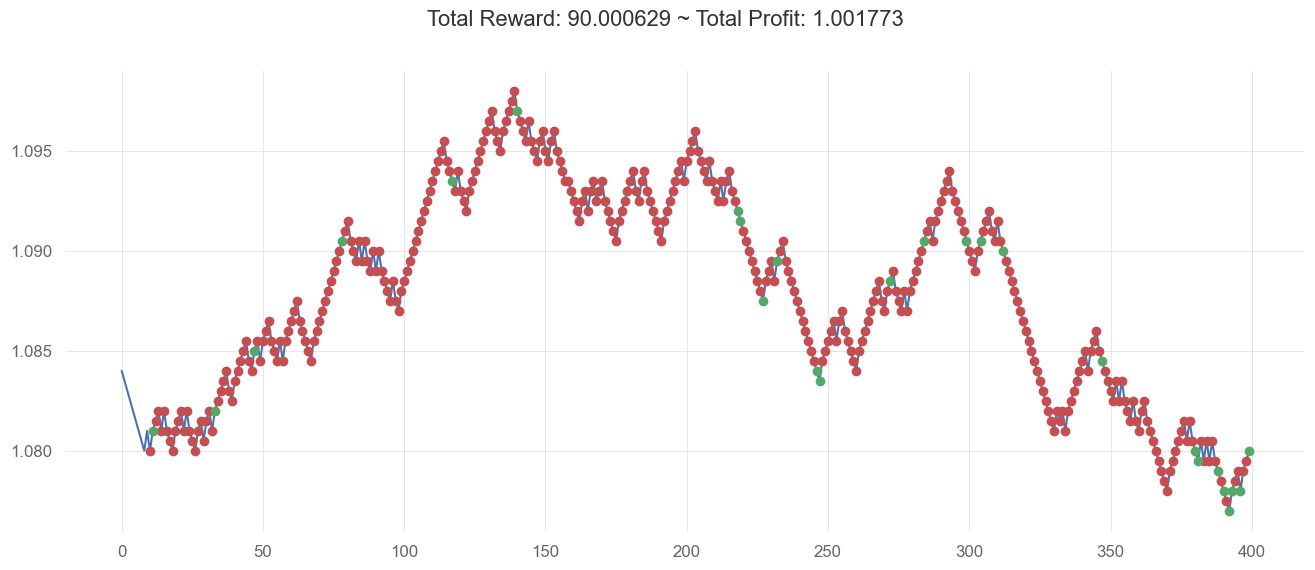

In [75]:
plt.figure(figsize=(16, 6))
env_test.unwrapped.render_all()
plt.show()

In [76]:
qs.extend_pandas()
window_size = 10


net_worth = pd.Series(env_test.unwrapped.history['total_profit'], index=FOREX_EURUSD_RENKO.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='SB3_a2c_quantstats_ppo_Billy.html')

ValueError: Length of values (389) does not match length of index (392)